In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point
import dask.dataframe as dd
import dask.distributed
from dask.distributed import Client

In [2]:
#clean_data = pd.read_pickle('data/clean_data.pickle')

In [23]:
#clean_fare = pd.read_pickle('data/clean_fare.pickle')

In [2]:
clean_data = pd.read_pickle('data/merged_data.pickle')

# Basic Questions

## a. What is the distribution of number of passengers per trip?

In [3]:
# Count the number of observations that belong to each value of 
# passenger count. Storing as a dataframe for plotting.
def get_distribution(df, group):
    """Count the number of observations that belong to each value of 
    passenger count. Storing as a dataframe for plotting.
    
    Params: 
        #TODO
    Returns:
        #TODO
    """
    df = pd.DataFrame(df.groupby(group)
                      .count()
                      .iloc[:,0])
    df = (df.rename(columns={df.columns[0]: "counts"})
          .reset_index())
    return df

passenger_dist = (clean_data.groupby('passenger_count')
                  .count()
                  .iloc[:,0])
passenger_dist = pd.DataFrame(passenger_dist).rename(columns={"medallion": "counts"})
passenger_dist.reset_index(inplace=True)

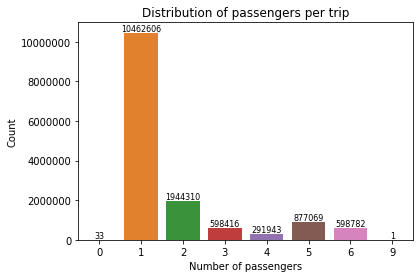

In [4]:
passenger_plot = sns.barplot(data=passenger_dist, 
                             x = "passenger_count", 
                             y="counts")
plt.title("Distribution of passengers per trip")
passenger_plot.set_xlabel("Number of passengers")
passenger_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(passenger_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()

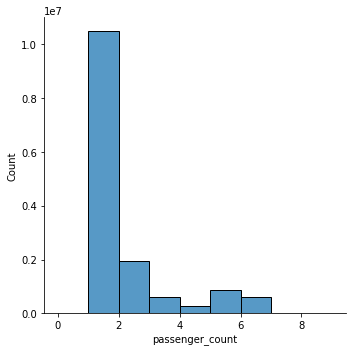

In [5]:
sns.displot(data = clean_data, 
            x = "passenger_count", 
            kind="hist", 
            bins = [0,1,2,3,4,5,6,7,8,9])

**Summary**

## b. What is the distribution of payment_type?

In [6]:
payment_dist = (clean_data.groupby('payment_type')
                .count()
                .iloc[:,0])
payment_dist = pd.DataFrame(payment_dist).rename(columns={"medallion": "counts"})
payment_dist.reset_index(inplace=True)

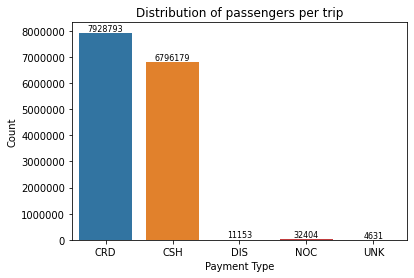

In [7]:
payment_plot = sns.barplot(data=payment_dist, 
                           x = "payment_type", 
                           y = "counts")
plt.title("Distribution of passengers per trip")
payment_plot.set_xlabel("Payment Type")
payment_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', 
                     axis='y')
payment_plot.bar_label(payment_plot.containers[0],
                       size=8,
                       fmt="%d")
plt.show()

**Summary**

Credit, Cash, Dispute, No charge, unkown

## c. What is the distribution of fare amount?

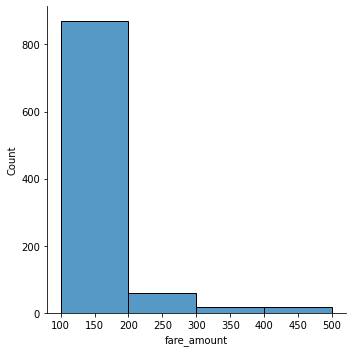

In [8]:
fare_plot = sns.displot(data=clean_data,
                        x="fare_amount",
                        kind="hist",
                        bins=[100, 200, 300, 400, 500])
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

## d. What is the distribution of tip amount?

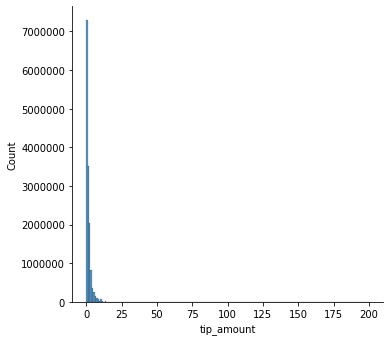

In [9]:
tip_plot = sns.displot(data=clean_data,
                       x="tip_amount",
                       kind="hist",
                       binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

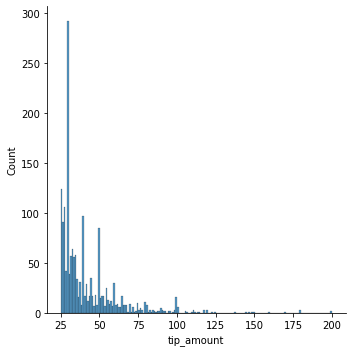

In [13]:
clean_tip_no_zero = clean_data[clean_data['tip_amount'] > 25]
sns.displot(data=clean_tip_no_zero,
            x="tip_amount",
            kind="hist",
            binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

Periodicity in the tip amount?

## e. What is the distribution of total amount?

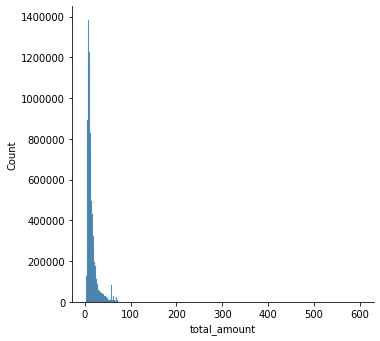

In [12]:
sns.displot(data=clean_data,
            x="total_amount",
            kind="hist",
            binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')

**Summary**

## f. What are top 5 busiest hours of the day?

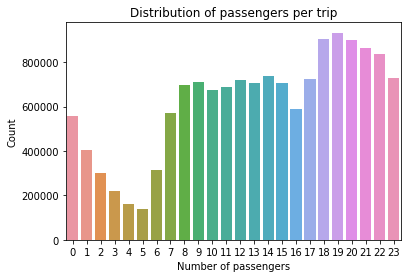

In [14]:
time_dist = get_distribution(clean_data, 
                             clean_data.pickup_datetime.dt.hour)
time_plot = sns.barplot(data=time_dist, 
                        x="pickup_datetime", 
                        y="counts")
plt.title("Distribution of passengers per trip")
time_plot.set_xlabel("Number of passengers")
time_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(time_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()

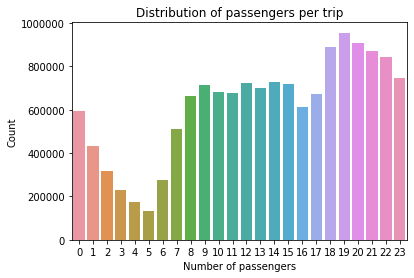

In [15]:
time_dist = get_distribution(clean_data, clean_data.dropoff_datetime.dt.hour)
time_plot = sns.barplot(data=time_dist, 
                        x = "dropoff_datetime", 
                        y="counts")
plt.title("Distribution of passengers per trip")
time_plot.set_xlabel("Number of passengers")
time_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', 
                     axis='y')
passenger_plot.bar_label(time_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()

## g. What are the top 10 busiest locations of the city?

### Labeling the pickup and dropoff zones to use in the next questions

At this point working with geopandas was becoming too cumbersome for my ram, time to use dask!

### Calculating the top 10 pickup zones

In [26]:
# Count the number of times a pickup occured in a zone, sort by the highest counts
top_10_pickup_zones = (clean_data.groupby("pickup_zone")
                    .count()
                    .sort_values(clean_data.columns[0],
                                 ascending=False)
                    .loc[:,clean_data.columns[0]])
top_10_pickup_zones.name = "count"

<AxesSubplot:ylabel='pickup_zone'>

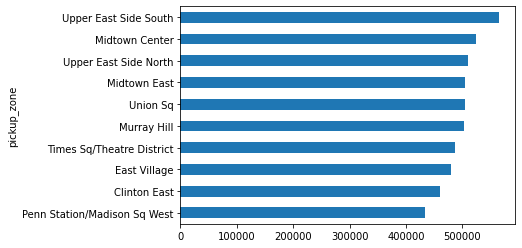

In [33]:
(top_10_pickup_zones
 .head(10)
 .sort_values(ascending=True)
 .plot(x="zone", 
       y="count", 
       kind="barh"))

## h. Which trip has the highest standard deviation of travel time?

In [34]:
trip_stddev = (clean_data
               .groupby("trip")
               .std()
               .sort_values("trip_time_in_secs", 
                            ascending=False)
               .head(1))

In [35]:
print("Trip with the highest standard deviation of travel time:", trip_stddev.index.values[0])
print("stddev: ", "{}".format(round(trip_stddev.trip_time_in_secs.values[0])))

Trip with the highest standard deviation of travel time: Whitestone to JFK Airport
stddev:  5599


## i. Which trip has most consistent fares?

In [36]:
fares_stddev = (clean_data
                .groupby("trip")
                .std()
                .sort_values("trip_time_in_secs", 
                             ascending=False)
                .head(1))

In [37]:
trip_fare_stddev = (clean_data
                    .groupby("trip")
                    .std()
                    .sort_values("fare_amount", 
                                 ascending=True)["fare_amount"])

trip_fare_count = (clean_data
                   .groupby("trip")
                   .count()
                   .sort_values("fare_amount", 
                                ascending=True)["fare_amount"])

In [38]:
trip_fare_summary = (clean_data[["trip", "fare_amount"]]
                     .groupby("trip")
                     .agg(["count", "std"]))

In [40]:
"""

"""

trip_fare_summary[trip_fare_summary["fare_amount"]["count"] > 30].sort_values(("fare_amount", "std"), ascending=True)

fare_amount           
                                                count        std
trip                                                            
Baisley Park to Gramercy                           39   0.000000
Baisley Park to East Village                       34   0.000000
Baisley Park to Midtown South                      87   0.000000
Springfield Gardens South to Midtown East          32   0.000000
Hamilton Heights to JFK Airport                    93   0.000000
...                                               ...        ...
Woodside to East Williamsburg                      36  33.748427
Newark Airport to Newark Airport                  741  35.792493
Hillcrest/Pomonok to Hillcrest/Pomonok            110  40.565660
North Corona to North Corona                       37  41.563381
Howard Beach to Howard Beach                       34  51.282711

[9753 rows x 2 columns]

# Open Questions

## a. In what trips can you confidently use respective means as measures of central tendency to estimate fare, time taken, etc.

## b. Can we build a model to predict fare and tip amount given pick up and drop off coordinates, time of day and week?

## c. If you were a taxi owner, how would you maximize your earnings in a day?

## d. If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?

## e. If you run a taxi company with 10 taxis, how would you maximize your earnings?